## Instructions {-}

1. This template serves as the required format for your code and report submission for the Prediction Problem assignment.
2. You may modify the template to improve readability or add relevant details, but it must include all requested information.
3. Ensure that your work is reproducible, meaning your code should consistently yield a metric value close to your Kaggle leaderboard score despite inherent randomness in data science.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import accuracy_score

In [4]:
train_X = pd.read_csv('train_X.csv')
train_y = pd.read_csv('train_y.csv')
df = train_X
df['ON_TIME_AND_COMPLETE'] = train_y['ON_TIME_AND_COMPLETE']
test_X = pd.read_csv('public_private_X.csv')

## 1) Exploratory Data Analysis (EDA)

* Summarize key insights obtained from the dataset.
* Discuss trends, correlations, or anomalies that influenced your modeling decisions.
* Provide relevant data visualizations (e.g., histograms, scatter plots, correlation matrices) to support your findings.

### Correlation Analysis: ###

From comparing the correlation we can identify predictors that are more correlated with y (some should be categorical despite having numeric categories). 

We also recognize predictors that are highly correlated with each other, raising the problem of multi-collinearity.

In [5]:
df.select_dtypes(include=["int","float"]).corr()['ON_TIME_AND_COMPLETE'].abs().sort_values(ascending=False)

ON_TIME_AND_COMPLETE                     1.000000
PRODUCT_CLASSIFICATION                   0.266281
COMPANY_VENDOR_NUMBER                    0.238684
PURCHASE_FROM_VENDOR                     0.199145
PURCHASING_LEAD_TIME                     0.164594
DAYS_BETWEEN_ORDER_AND_DUE_DATE          0.141651
TRANSIT_LEAD_TIME                        0.128883
DISTANCE_IN_MILES                        0.118058
AVERAGE_ORDER_CYCLE_DAYS                 0.113561
GIVEN_TIME_TO_LEAD_TIME_RATIO            0.101843
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET    0.095015
AVERAGE_DAILY_DEMAND_CASES               0.091601
AVERAGE_VENDOR_ORDER_CYCLE_DAYS          0.076440
SHIP_FROM_VENDOR                         0.068787
LEAD_TIME_TO_DISTANCE_RATIO              0.060109
ORDER_DAY_OF_WEEK                        0.028731
DIVISION_NUMBER                          0.025631
PRODUCT_MARKET                           0.018960
DUE_DATE_WEEKDAY                         0.015874
PRODUCT_NUMBER                           0.011300


In [6]:
corr_matrix = df.select_dtypes(include=["int","float"]).corr()
mask = (corr_matrix >= 0.5) & (corr_matrix != 1)
corr_matrix[mask].stack().sort_values(ascending=False)

PURCHASING_LEAD_TIME                   DAYS_BETWEEN_ORDER_AND_DUE_DATE          0.957562
DAYS_BETWEEN_ORDER_AND_DUE_DATE        PURCHASING_LEAD_TIME                     0.957562
TRANSIT_LEAD_TIME                      PURCHASING_LEAD_TIME                     0.864590
PURCHASING_LEAD_TIME                   TRANSIT_LEAD_TIME                        0.864590
TRANSIT_LEAD_TIME                      DAYS_BETWEEN_ORDER_AND_DUE_DATE          0.853955
DAYS_BETWEEN_ORDER_AND_DUE_DATE        TRANSIT_LEAD_TIME                        0.853955
AVERAGE_VENDOR_ORDER_CYCLE_DAYS        AVERAGE_ORDER_CYCLE_DAYS                 0.843005
AVERAGE_ORDER_CYCLE_DAYS               AVERAGE_VENDOR_ORDER_CYCLE_DAYS          0.843005
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET  AVERAGE_ORDER_CYCLE_CASES                0.745292
AVERAGE_ORDER_CYCLE_CASES              AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET    0.745292
COMPANY_VENDOR_NUMBER                  SHIP_FROM_VENDOR                         0.730550
SHIP_FROM_VENDOR     

### Distribution of Variables: ###

Aside from the correlations, the pairplot also shows some distribution issues that may need to be addressed.

- The range of these categorical variables differs by a lot, so may need to standardize them.
- Some density plots seem be have very long tails, need to check for influential points and handle them (whether they had influence was checked using Cook's distance after the model in section 4, there was actually none so no handling is written here).
    - also need to square them in the model

In [7]:
correlated_X = ['PRODUCT_CLASSIFICATION', 'COMPANY_VENDOR_NUMBER','PURCHASE_FROM_VENDOR','PURCHASING_LEAD_TIME','DAYS_BETWEEN_ORDER_AND_DUE_DATE', 'TRANSIT_LEAD_TIME','DISTANCE_IN_MILES','AVERAGE_ORDER_CYCLE_DAYS','GIVEN_TIME_TO_LEAD_TIME_RATIO','SHIP_FROM_VENDOR','AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET']

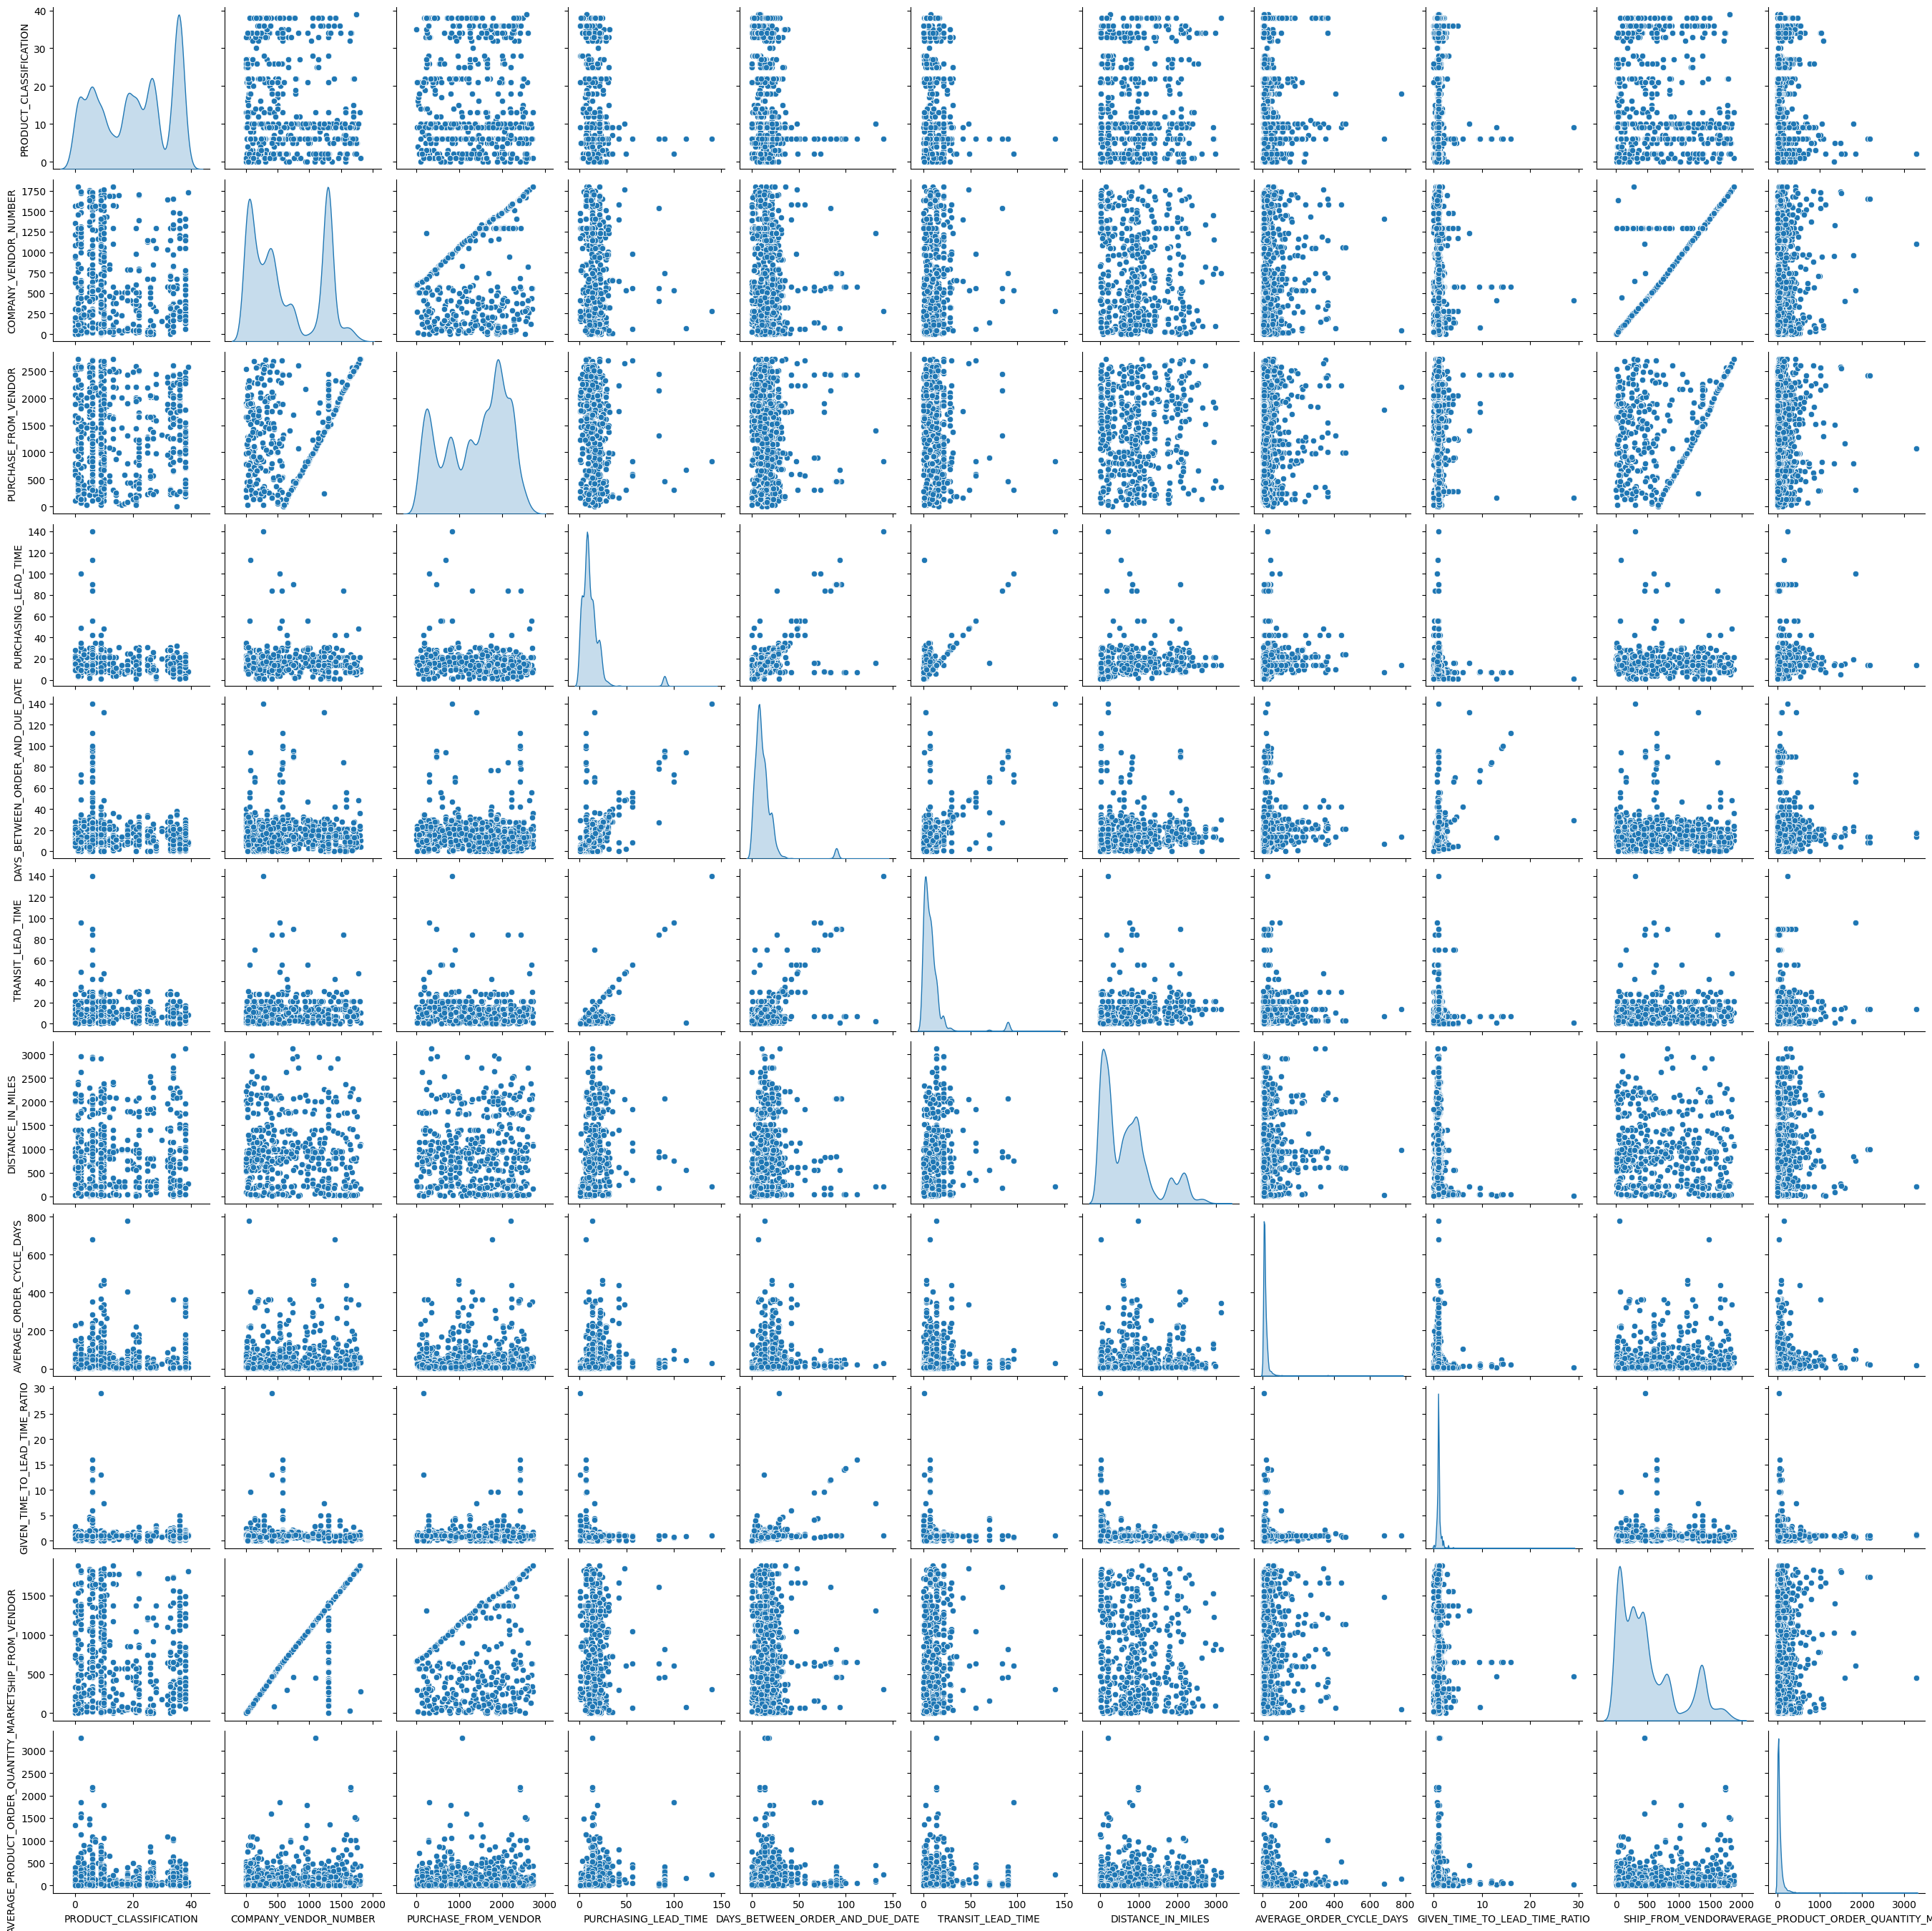

In [8]:
sns.pairplot(df.loc[:,correlated_X], diag_kind='kde')

In [9]:
df_clean = df_corr = df.loc[:,correlated_X] 
df_clean['ON_TIME_AND_COMPLETE'] = df['ON_TIME_AND_COMPLETE']

### Missing Values Identification: ###

- It seems like only average order cycle days has missing values that may be imputed.

In [10]:
df_clean.isnull().sum()

PRODUCT_CLASSIFICATION                     0
COMPANY_VENDOR_NUMBER                      0
PURCHASE_FROM_VENDOR                       0
PURCHASING_LEAD_TIME                       0
DAYS_BETWEEN_ORDER_AND_DUE_DATE            0
TRANSIT_LEAD_TIME                          0
DISTANCE_IN_MILES                          0
AVERAGE_ORDER_CYCLE_DAYS                 339
GIVEN_TIME_TO_LEAD_TIME_RATIO              0
SHIP_FROM_VENDOR                           0
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET      0
ON_TIME_AND_COMPLETE                       0
dtype: int64

## 2) Data Preprocessing

Describe any preprocessing steps performed on your dataset. This may include imputing missing values, creating dummy variables, combining levels of categorical variable(s), discarding predictors that are not useful, etc.

The data preprocessing process includes:
- Outlier handling (no actual outliers identified)
- Impute missing values from AVERAGE_ORDER_CYCLE_DAYS
- Identify categorical variables right now presented as numerical
    - dummy variables will be created using pipeline in section 4

In [11]:
# impute missing values using the median
df_clean['AVERAGE_ORDER_CYCLE_DAYS'] = df_clean['AVERAGE_ORDER_CYCLE_DAYS'].fillna(df_clean['AVERAGE_ORDER_CYCLE_DAYS'].median())
test_X['AVERAGE_ORDER_CYCLE_DAYS'] = test_X['AVERAGE_ORDER_CYCLE_DAYS'].fillna(test_X['AVERAGE_ORDER_CYCLE_DAYS'].median())

In [12]:
from sklearn.model_selection import train_test_split
X = df_clean.drop('ON_TIME_AND_COMPLETE', axis=1)
y = df_clean['ON_TIME_AND_COMPLETE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train

,PRODUCT_CLASSIFICATION,COMPANY_VENDOR_NUMBER,PURCHASE_FROM_VENDOR,PURCHASING_LEAD_TIME,DAYS_BETWEEN_ORDER_AND_DUE_DATE,TRANSIT_LEAD_TIME,DISTANCE_IN_MILES,AVERAGE_ORDER_CYCLE_DAYS,GIVEN_TIME_TO_LEAD_TIME_RATIO,SHIP_FROM_VENDOR,AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET
18527,27,1144,1252,13.0,13,2.0,225.36,5.803371,0.87,1218,30.00
18688,21,46,391,21.0,15,2.0,955.48,18.738016,0.65,47,48.00
2679,18,409,798,9.0,7,7.0,562.29,9.617528,0.78,460,19.06
2352,1,1296,1628,13.0,11,0.0,240.98,8.264669,0.85,6,8.38
10956,2,45,1284,14.0,14,3.0,1209.96,7.000000,0.82,46,56.47
...,...,...,...,...,...,...,...,...,...,...,...
14947,36,1295,1582,2.0,2,0.0,43.60,7.000000,1.00,853,7.77
12066,1,1296,1633,12.0,11,0.0,753.96,8.264669,0.92,1372,4.15
6079,1,1577,2219,15.0,15,15.0,459.02,5.826816,1.00,1655,268.26
4247,36,1295,1578,12.0,14,7.0,2103.04,7.000000,0.74,101,97.62


In [13]:
numeric = ['PURCHASING_LEAD_TIME', 'TRANSIT_LEAD_TIME', 'DISTANCE_IN_MILES','AVERAGE_ORDER_CYCLE_DAYS','DAYS_BETWEEN_ORDER_AND_DUE_DATE']
categorical = ['PRODUCT_CLASSIFICATION','COMPANY_VENDOR_NUMBER','SHIP_FROM_VENDOR','PURCHASE_FROM_VENDOR']
skewed = ['DAYS_BETWEEN_ORDER_AND_DUE_DATE', 'TRANSIT_LEAD_TIME', 'DISTANCE_IN_MILES','AVERAGE_ORDER_CYCLE_DAYS']
all = numeric + categorical
X_train = X_train[all]

## 3) Feature Engineering

* List and explain the new features you created (if any).
* Justify why these features were added and how they contribute to improving the model.

Mention the logical/intuitive steps you took to obtain the final model. This may include identifying transformations, significant interactions, variable selection, etc. You do not need to put any code here.

The main logic used for feature selection here is to include predictors that actually increased the model accuracy on more than 5 different train test splits. Matching the analysis in section 1, the numerical variables were scaled then squared and the categorical variables were encoded using onehotencoder. I tried to include some interaction terms between variables that I thought would logically have influence over eachother, but none of them actually increased the accuracy.

## 4) Model Selection and Training

Put your model here.

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(
            [('scalar', StandardScaler()), 
             ('poly', PolynomialFeatures(degree=2))]), numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical)
    ]
)

In [16]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=10000))
])
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  ['PURCHASING_LEAD_TIME',
                                                   'TRANSIT_LEAD_TIME',
                                                   'DISTANCE_IN_MILES',
                                                   'AVERAGE_ORDER_CYCLE_DAYS',
                                                   'DAYS_BETWEEN_ORDER_AND_DUE_DATE']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['PRODUCT_CLASSIFICATION',
                                                   'COMPANY_VENDOR_NUMBER',
                                                   'SHIP_FROM_VENDOR',
                                                   'PURCHASE_FROM_VENDOR'])])),
                ('classifier', LogisticRegression(max_iter=10000))])

### Cook's Distance Influential Point Detection ###

The threshold used is 1, no outlier detected.

In [17]:
model = pipeline.named_steps['classifier']
X_train_with_intercept = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_with_intercept).fit()
influence = logit_model.get_influence()
cooks = influence.cooks_distance[0]
threshold = 1
outliers = cooks > threshold
outlier_indices = X_train.index[outliers]
X_train.loc[outlier_indices]

Optimization terminated successfully.
         Current function value: 0.624280
         Iterations 5


,PURCHASING_LEAD_TIME,TRANSIT_LEAD_TIME,DISTANCE_IN_MILES,AVERAGE_ORDER_CYCLE_DAYS,DAYS_BETWEEN_ORDER_AND_DUE_DATE,PRODUCT_CLASSIFICATION,COMPANY_VENDOR_NUMBER,SHIP_FROM_VENDOR,PURCHASE_FROM_VENDOR


## 5) Model Prediction and Evaluation

Please note that your code for Questions 2, 4, and 5 will be executed sequentially, and it should generate a metric value close to the one displayed next to your name on the Kaggle leaderboard. While minor variations due to randomness in data science are expected, your implementation must be consistent and reproducible to receive full credit.

In [18]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

In [19]:
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

0.7898862337379565
0.7796278158667973


## 6) Complete Code Submission

* Provide a link to your Kaggle notebook or a GitHub repository containing your code.
* Ensure the notebook is properly commented and reproducible.

In [20]:
submission_pred = pipeline.predict(test_X)

In [21]:
submission_csv = pd.read_csv('sample_submission.csv')
submission_csv['ON_TIME_AND_COMPLETE'] = submission_pred
submission_csv

,ID,ON_TIME_AND_COMPLETE
0,11,1
1,19,1
2,20,1
3,23,1
4,24,1
...,...,...
10242,30641,1
10243,30642,0
10244,30654,1
10245,30657,0


In [22]:
submission_csv.to_csv("submission_interim.csv", index=False)

## 7) Reflection and Challenges

* Discuss any challenges faced during this process and how they were addressed.
* Mention any improvements you would make for the next steps

Challenges & improvements:
- The feature selection process is a bit arbituary and there are a lot of predictors, need to test for overfitting and consider how to systematically select useful features
- Currently ignoring date predictors, would like to explore datetime variables.
- Unsure whether the Pipeline is actually learning well from the categorical variables because they didn't go through preprocessing (a lot of categories) but somehow it is running very fast.
- Need to find appropriate interaction terms.
- Possibly try more sensitive thresholds for Cook's distance.